In [1]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [2]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir(r"D:/project1/dataset/train/")
labels = []

for filename in filenames:
    label = filename.split(' ')[0]
    if label == 'good':
        labels.append(0)
    else:
        labels.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

In [4]:
df.head(1000)

,filename,label
0,bad (1)k.jpeg,1
1,bad (10)k.jpeg,1
2,bad (100)k.jpeg,1
3,bad (101)k.jpeg,1
4,bad (102)k.jpeg,1
...,...,...
995,good (522)k.jpeg,0
996,good (523)k.jpeg,0
997,good (524)k.jpeg,0
998,good (525)k.jpeg,0


<AxesSubplot:>

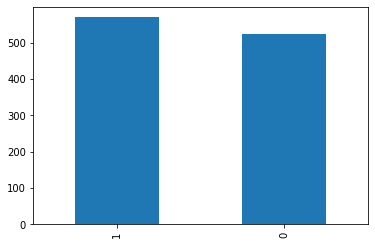

In [5]:
df['label'].value_counts().plot.bar()

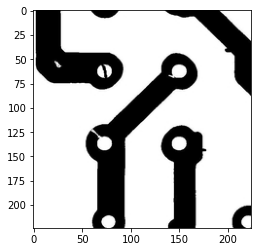

In [6]:
sample = random.choice(filenames)
image = load_img(r"D:/project1/dataset/train/"+sample)
plt.imshow(image)

In [7]:
base_model=MobileNet(weights='imagenet',include_top=False)  #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)                          #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x)                          #dense layer 2
x=Dense(512,activation='relu')(x)                           #dense layer 3
preds=Dense(2,activation='softmax')(x)                      #final layer with softmax activation

In [8]:
model=Model(inputs=base_model.input,outputs=preds)

In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy']) 

In [10]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [11]:
earlystop = EarlyStopping(patience=10)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

In [14]:
df["label"] = df["label"].replace({0: 'Good', 1: 'Bad'}) 

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

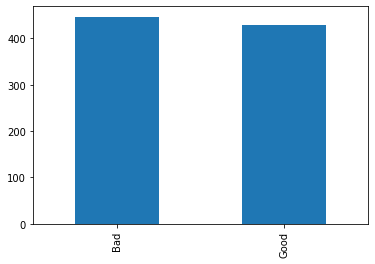

In [16]:
train_df['label'].value_counts().plot.bar()

<AxesSubplot:>

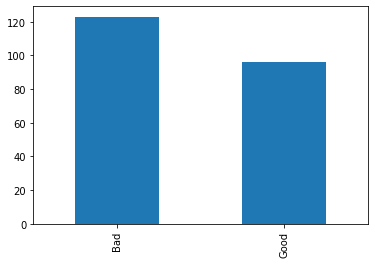

In [17]:
validate_df['label'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    r"D:/project1/dataset/train", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 876 validated image filenames belonging to 2 classes.


In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"D:/project1/dataset/train", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)    

Found 219 validated image filenames belonging to 2 classes.


In [21]:
epochs=3 if FAST_RUN else 20
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\HP\AppData\Local\Temp\ipykernel_5452\2960438613.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
58/58 [==============================] - 185s 3s/step - loss: 0.6095 - accuracy: 0.7758 - val_loss: 3.2233 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/20
58/58 [==============================] - 176s 3s/step - loss: 0.3018 - accuracy: 0.8990 - val_loss: 0.3904 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 3/20
58/58 [==============================] - 158s 3s/step - loss: 0.2561 - accuracy: 0.9187 - val_loss: 0.2571 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 4/20
58/58 [==============================] - 151s 3s/step - loss: 0.1986 - accuracy: 0.9350 - val_loss: 0.1522 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 5/20
58/58 [==============================] - 153s 3s/step - loss: 0.1970 - accuracy: 0.9315 - val_loss: 0.0840 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 6/20
58/58 [==============================] - 153s 3s/step - loss: 0.1357 - accuracy: 0.9512 - val_loss: 0.1151 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 7/20
58/58 [==============================] - ETA: 0s - loss: 0.1164 -

In [22]:
model.save_weights("model.h5")

In [23]:
model.save('D:/project1/model.h5')

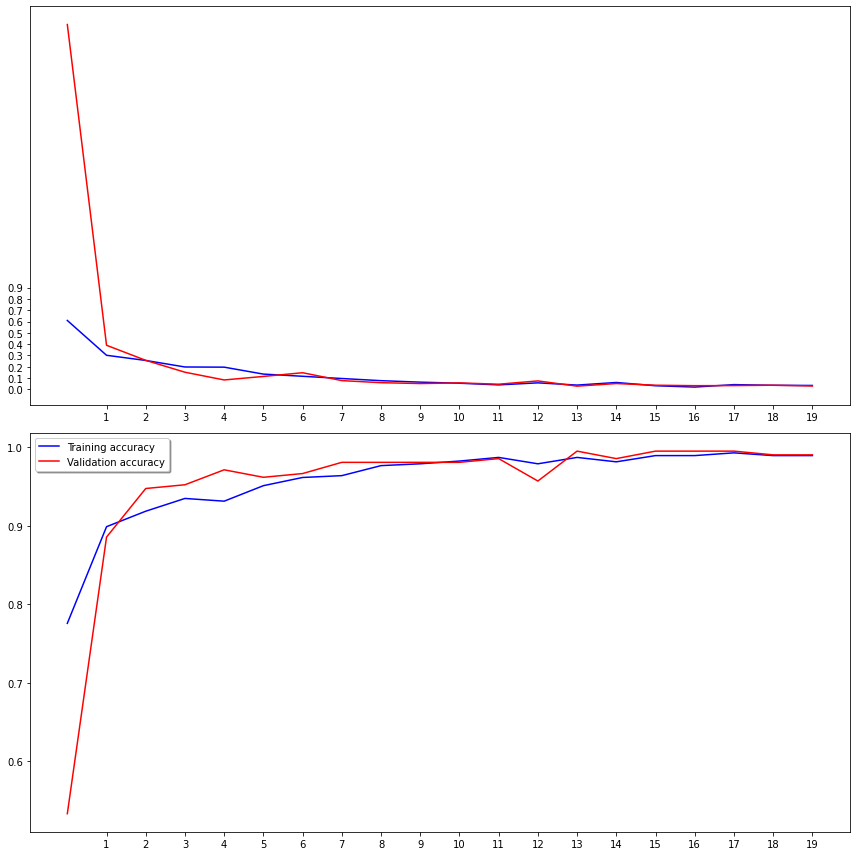

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [25]:
model = load_model(r'D:/project1/model.h5')

In [26]:
import cv2
img = cv2.imread(r'D:/project1/dataset/test/bad (451)k.jpeg')
img = img[...,::-1]                                                                 #give right image or else it will show error
model.predict(img[None,...], batch_size=None, verbose=2, steps=1)

1/1 - 1s - 1s/epoch - 1s/step


array([[0.52128357, 0.47871643]], dtype=float32)

In [42]:
test_filenames = os.listdir(r"D:/project1/dataset/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"D:/project1/dataset/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


In [37]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [38]:
test_df['label'] = np.argmax(predict, axis=-1)

In [39]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)

<AxesSubplot:>

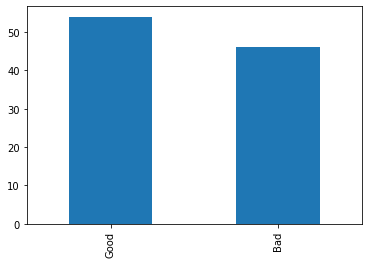

In [40]:
test_df['label'].value_counts().plot.bar()

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['label']
    img = load_img(r"D:/project1/dataset/test"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + (' ') + 'Result-' + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()